In [1693]:
import pandas as pd
import numpy as np
import statistics

import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats

import operator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

### **Import** DataBase

In [1694]:
df = pd.read_csv('Property_structured_data.csv')

In [1695]:
df_shape_initial = df.shape

### **Clean** DataBase

Transform the data into digits, drop elements that are outliers, change -1 to 1 (Nan = -1 in this DataBase)

#### **Price** (float)

In [1696]:
z_scores_price = stats.zscore(df['price'])
abs_z_scores_price = np.abs(z_scores_price) 
filtered_entries_price = (abs_z_scores_price < 1)
df = df[filtered_entries_price]

In [1697]:
df= df.loc[df['price'] != -1]

#### **Surface** (float)

In [1698]:
df = df.loc[df['surface'] <= 800]

In [1699]:
df = df.loc[df['surface'] >= 35]

In [1700]:
df = df.loc[df['surface'] != -1]

#### **Sub type of property** (str)

In [1701]:
df['subtype_of_property'].value_counts()

HOUSE                   19895
APARTMENT               15178
VILLA                    2083
DUPLEX                   1179
APARTMENT_BLOCK          1100
GROUND_FLOOR             1097
MIXED_USE_BUILDING        839
PENTHOUSE                 809
SERVICE_FLAT              469
FLAT_STUDIO               450
TOWN_HOUSE                367
MANSION                   358
EXCEPTIONAL_PROPERTY      355
COUNTRY_COTTAGE           253
BUNGALOW                  239
LOFT                      197
FARMHOUSE                 123
TRIPLEX                   106
CHALET                    101
OTHER_PROPERTY             56
MANOR_HOUSE                33
KOT                         8
CASTLE                      4
PAVILION                    1
Name: subtype_of_property, dtype: int64

In [1702]:
df= df.loc[df['subtype_of_property'] != 'APARTMENT_BLOCK']

In [1703]:
df= df.loc[df['subtype_of_property'] != 'MIXED_USE_BUILDING']

In [1704]:
others = ["CHALET", "MANOR_HOUSE", "OTHER_PROPERTY", "CASTLE", "PAVILION"]

In [1705]:
df.loc[df["subtype_of_property"].isin(others), "type_of_property"] = "OTHER"

#### **Number of bedrooms** (int)

In [1706]:
df = df.loc[df['number_of_bedrooms'] <20]

In [1707]:
df['type_of_property'] = np.where((df['number_of_bedrooms'] > 20), "OTHER", df['type_of_property'])

In [1708]:
df['number_of_bedrooms'] = df['number_of_bedrooms'].replace(-1,0)

#### **Zip Code** (category)

In [1709]:
df['zip_code_xx'] = df['postal_code'].apply(lambda x : 'be_zip_'+str(x)[:3])

#### **Land surface** (float)

In [1710]:
df['land_surface'] = [land_surface if land_surface != -1 else garden_surface if garden_surface > 0 else land_surface for garden_surface,land_surface in zip(df['garden_surface'],df['land_surface'])]

In [1711]:
df['land_surface'] = df['land_surface'].replace(-1,0)

#### **Garden** (0,1)

In [1712]:
df['garden'] = df['garden'].replace(-1,0)

#### **Garden surface** (float)

In [1713]:
df['garden_surface'] = df['garden_surface'].replace(-1,0)

In [1714]:
df['garden_surface'] = df['garden_surface'].replace(1,0)

In [1715]:
df.loc[(df["garden_surface"] > 2000) & (df['type_of_property'] == 'APARTMENT'),'type_of_property'] = "OTHER"

#### **Fully equiped kitchen** (int)

In [1716]:
df["fully_equipped_kitchen"] = df["fully_equipped_kitchen"].map({"-1.0": 0.25, "1.0": 1,"-1": 0.25, "1": 1, "INSTALLED": 0.5, "SEMI_EQUIPPED": 0.75, "NOT_INSTALLED": 0, "USA_INSTALLED": 0.5, "USA_SEMI_EQUIPPED": 0.75, "USA_UNINSTALLED": 0})

In [1717]:
#df["fully_equipped_kitchen"] = df["fully_equipped_kitchen"].map({"-1.0": 0, "1.0": 1,"-1": 0, "1": 1, "INSTALLED": 0, "SEMI_EQUIPPED": 1, "NOT_INSTALLED": 0, "USA_INSTALLED": 0, "USA_SEMI_EQUIPPED": 1, "USA_UNINSTALLED": 0})

#### **Swiming pool**  (0,1)

In [1718]:
df['swimming_pool'] = df['swimming_pool'].replace(-1,0)

#### **Furnished** (0,1)

In [1719]:
df['furnished'] = df['furnished'].replace(-1,0)

#### **Open fire** (0,1)

In [1720]:
df['open_fire'] = df['open_fire'].replace(-1,0)

#### **Terrace** (0,1)

In [1721]:
df['terrace'] = df['terrace'].replace(-1,0)

#### **Terrace surface** (float)

In [1722]:
df = df.loc[df['terrace_surface'] < 500]

In [1723]:
df['terrace_surface'] = df['terrace_surface'].replace(-1,0)

#### **Facades** (int)

In [1724]:
df = df.loc[df["number_of_facades"] < 9]

In [1725]:
df["number_of_facades"] = np.where((df["number_of_facades"] == -1) & (df["type_of_property"] == "APARTMENT"), 1, df["number_of_facades"])

In [1726]:
df["number_of_facades"] = np.where((df["number_of_facades"] == -1) & (df["type_of_property"] == "HOUSE"), 2, df["number_of_facades"])

In [1727]:
df = df.loc[df["number_of_facades"] != -1]

#### **State of the building** (int)

In [1728]:
df["state_of_the_building"] = df["state_of_the_building"].map({
    "NO_INFO": 0.25, #"TO_RENOVATE"
    "TO_BE_DONE_UP": 0.75, #"JUST_RENOVATED"
    "TO_RENOVATE": 0.25, #"TO_RENOVATE"
    "TO_RESTORE": 0.25, #"TO_REBUILD"
    "JUST_RENOVATED": 0.75, #"JUST_RENOVATED"
    "GOOD": 0.5, #"GOOD"
    "AS_NEW": 1.0 #"NEW"
})

#### **Type of property** (category)

In [1729]:
df_other = df.loc[df["type_of_property"] == "OTHER"]

In [1730]:
df= df.loc[df["type_of_property"] != "OTHER"]

### **Add Values** to DataBase

#### **price/m²** calculate(float)

In [1731]:
df['price_m2'] = round(df['price']/df['surface'],2)

#### **zipcode ratio** calculate(float)

Calculate the mean value of price/m² by zip

In [1732]:
df_zip_list = ['price_m2','zip_code_xx']

In [1733]:
df_zips = df[df_zip_list]

In [1734]:
xxx_zip = df_zips.groupby('zip_code_xx')

In [1735]:
xxx_zip_list = []  #stores the name of each zipcode from the data base
for key, values in xxx_zip:
    xxx_zip_list.append(key)

In [1736]:
df_zips_mean = round(df_zips.groupby('zip_code_xx').mean(),2)

In [1737]:
df_zips_mean_values = df_zips_mean.values  # calculates mean for each zipxx

In [1738]:
zip_mean = [] # stores the values as a list of mean for each zipxx
for x in df_zips_mean_values:
    for i in x:
        zip_mean.append(i)

In [1739]:
global_mean = statistics.mean(zip_mean)  #calculate a global mean

In [1740]:
xxx = [] #list of the ponderated means 
for y,i in enumerate(zip_mean):
    xxx.append(round(i/global_mean,2)) #calculates the relation of mean/zip code and the global mean

Send this to the data frame as a column

In [1741]:
dic_zip_value = dict()  #creates a dictionay for zipcodes and values
for i,x in enumerate(xxx_zip_list):
    dic_zip_value[x] = xxx[i]
    

In [1742]:
import csv
dic_zip_value

with open('diczipcoderatio.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for row in dic_zip_value.items():
        writer.writerow(row)


In [1743]:
df['zip_code_ratio'] = df['zip_code_xx']

In [1744]:
df['zip_code_ratio'] = df['zip_code_ratio'].map(dic_zip_value)


### **Check** DataBase

In [1745]:
filtered_atributes = [#'id',
 #'locality',
 #'postal_code',
 #'region',
 #'province',
 'type_of_property',
 #'subtype_of_property',
 #'type_of_sale',
 'price',
 'number_of_bedrooms',
 'surface',
 #'kitchen_type',
 'fully_equipped_kitchen',
 'furnished',
 'open_fire',
 'terrace',
 'terrace_surface',
 'garden',
 'garden_surface',
 'land_surface',
 'number_of_facades',
 'swimming_pool',
 'state_of_the_building',
 #'zip_code_xx',
 #'price_m2',
 'zip_code_ratio']

In [1746]:
df = df[filtered_atributes]

In [1747]:
df_shape_final = df.shape

In [1748]:
print(f'initial_df {df_shape_initial} claned_df {df_shape_final}')

initial_df (62430, 23) claned_df (43122, 16)


In [1749]:
df.describe()

,price,number_of_bedrooms,surface,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_surface,garden,garden_surface,land_surface,number_of_facades,swimming_pool,state_of_the_building,zip_code_ratio
count,43122.000000,43122.000000,43122.000000,43122.000000,43122.000000,43122.000000,43122.000000,43122.000000,43122.000000,43122.000000,4.312200e+04,43122.000000,43122.000000,43122.000000,43122.000000
mean,328583.237466,2.743588,148.213255,0.503281,0.022309,0.040096,0.635662,9.557975,0.341148,97.829206,4.549637e+02,2.381824,0.013868,0.554624,1.135574
std,153914.065231,1.229925,80.263773,0.278390,0.147688,0.196186,0.481250,18.972661,0.474101,598.034703,5.902189e+03,0.982350,0.116943,0.290758,0.371293
min,2500.000000,0.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.250000,0.460000
25%,220000.000000,2.000000,93.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000,0.250000,0.910000
50%,295000.000000,3.000000,130.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.300000e+01,2.000000,0.000000,0.500000,1.080000
75%,399000.000000,3.000000,180.000000,0.750000,0.000000,0.000000,1.000000,13.000000,1.000000,0.000000,4.200000e+02,3.000000,0.000000,0.750000,1.290000
max,849000.000000,17.000000,800.000000,1.000000,1.000000,1.000000,1.000000,420.000000,1.000000,55000.000000,1.100000e+06,6.000000,1.000000,1.000000,3.250000


In [1750]:
for index,atribute in enumerate(df.columns.to_list()):
    print(atribute)
    print(df[df.columns.to_list()[index]].value_counts())
    print('\n')

type_of_property
HOUSE        23659
APARTMENT    19463
Name: type_of_property, dtype: int64


price
299000    757
249000    668
295000    663
199000    614
275000    595
         ... 
308601      1
392865      1
237236      1
537334      1
316200      1
Name: price, Length: 3637, dtype: int64


number_of_bedrooms
3     14436
2     14345
4      6142
1      4621
5      2030
6       663
0       513
7       183
8        93
9        55
10       16
11       11
12        5
16        2
13        2
15        2
14        2
17        1
Name: number_of_bedrooms, dtype: int64


surface
100    873
150    870
90     830
120    801
110    702
      ... 
476      1
539      1
633      1
686      1
595      1
Name: surface, Length: 566, dtype: int64


fully_equipped_kitchen
0.50    16011
0.25    14123
1.00     7017
0.75     4199
0.00     1772
Name: fully_equipped_kitchen, dtype: int64


furnished
0    42160
1      962
Name: furnished, dtype: int64


open_fire
0    41393
1     1729
Name: open_fire, dtype

### **Separate** DataBase Houses / Apartments

In [1751]:
df_house = df.loc[df["type_of_property"] == "HOUSE"]

In [1752]:
df_apartment = df.loc[df["type_of_property"] == "APARTMENT"]

#### New boundaries

In [1753]:
df_house = df_house.loc[df_house['surface'] <= 500]

In [1754]:
df_apartment = df_apartment.loc[df_apartment['number_of_bedrooms'] <= 5]

In [1755]:
#df_apartment = df_apartment.loc[df_apartment['number_of_bedrooms'] >= 1]

In [1756]:
df_apartment = df_apartment.loc[df_apartment['price'] <= 700000]

In [1757]:
df_apartment = df_apartment.loc[df_apartment['surface'] <= 300]

### Data **Exploration**

#### **Select** atributes

In [1758]:
atributes_house=[#'type_of_property',
 'price',
 'number_of_bedrooms',
 'surface',
 'fully_equipped_kitchen',
 #'furnished',
 'open_fire',
 #'terrace',
 #'terrace_surface',
 #'garden',
 #'garden_surface',
 #'land_surface',
 'number_of_facades',
 'swimming_pool',
 'state_of_the_building',
 'zip_code_ratio']

In [1759]:
df_house = df_house[atributes_house]

In [1760]:
atributes_apartment=[#'type_of_property',
 'price',
 'number_of_bedrooms',
 'surface',
 'fully_equipped_kitchen',
 #'furnished',
 #'open_fire',
 'terrace',
 'terrace_surface',
 #'garden',
 #'garden_surface',
 #'land_surface',
 #'number_of_facades',
 #'swimming_pool',
 'state_of_the_building',
 'zip_code_ratio']

In [1761]:
df_apartment = df_apartment[atributes_apartment]

#### Attributes **correlation**

use lasso

In [1762]:
df_house.corr()['price']

price                     1.000000
number_of_bedrooms        0.386389
surface                   0.563293
fully_equipped_kitchen    0.213299
open_fire                 0.148348
number_of_facades         0.255955
swimming_pool             0.162788
state_of_the_building     0.174704
zip_code_ratio            0.491941
Name: price, dtype: float64

**Relationship of house atributes wit price:**
* **number_of_bedrooms        0.384784**
* **surface                   0.533437**
* fully_equipped_kitchen    0.209290
* open_fire                 0.145386
* number_of_facades         0.253947
* swimming_pool             0.160394
* state_of_the_building     0.173194
* **zip_code_ratio            0.446084**

In [1763]:
df_apartment.corr()['price']

price                     1.000000
number_of_bedrooms        0.410903
surface                   0.574051
fully_equipped_kitchen    0.171247
terrace                   0.194913
terrace_surface           0.302033
state_of_the_building     0.143207
zip_code_ratio            0.455725
Name: price, dtype: float64

**Relationship of apartment atributes wit price:**
* **number_of_bedrooms        0.410458**
* **surface                   0.537731**
* fully_equipped_kitchen    0.170661
* terrace                   0.177441
* **terrace_surface           0.301534**
* state_of_the_building     0.150617
* **zip_code_ratio            0.341447**

#### Data **Exploration**

In [1764]:
def plt_chart(chart_x, chart_y, chart_title, chart_x_label, chart_y_label):
    plt.scatter(chart_x, chart_y)
    plt.title(chart_title)
    plt.ylabel(chart_y_label)
    plt.xlabel(chart_x_label)
    return plt

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

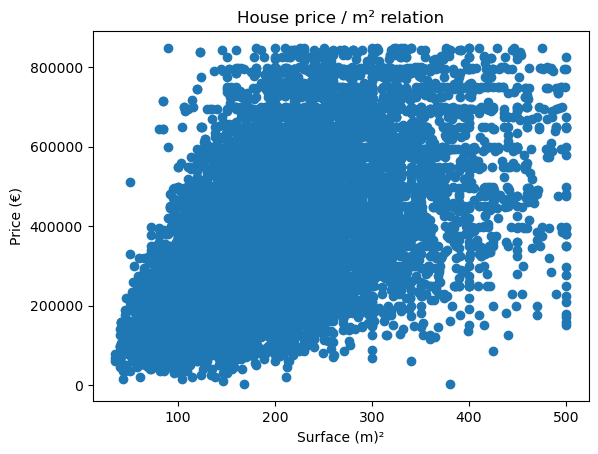

In [1765]:
plt_chart(df_house['surface'],df_house['price'],'House price / m² relation','Surface (m)²','Price (€)')

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

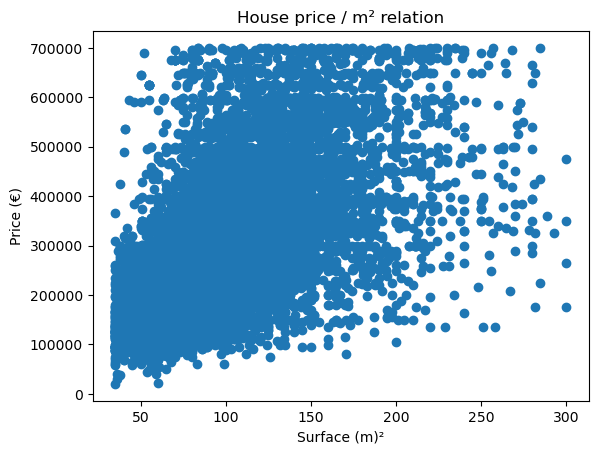

In [1766]:
plt_chart(df_apartment['surface'],df_apartment['price'],'House price / m² relation','Surface (m)²','Price (€)')

/tmp/ipykernel_4873/2064535743.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_house['price'], bins=30)


<AxesSubplot:xlabel='price', ylabel='Density'>

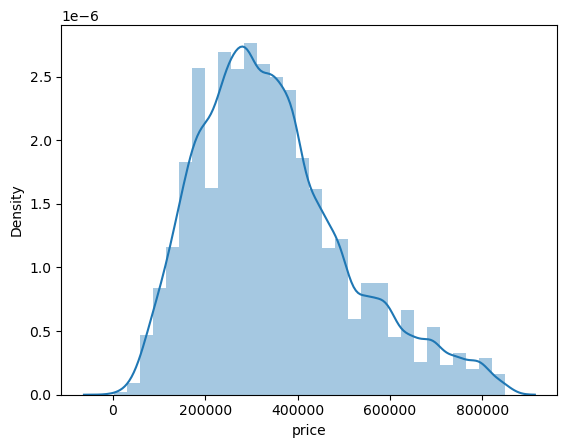

In [1767]:
sns.distplot(df_house['price'], bins=30)

/tmp/ipykernel_4873/2610420630.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_apartment['price'], bins=30)


<AxesSubplot:xlabel='price', ylabel='Density'>

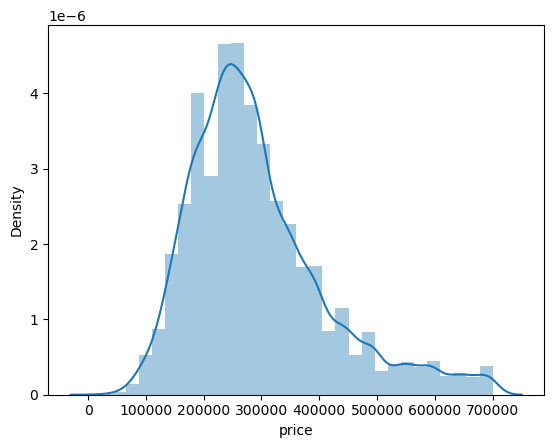

In [1768]:
sns.distplot(df_apartment['price'], bins=30)

<AxesSubplot:>

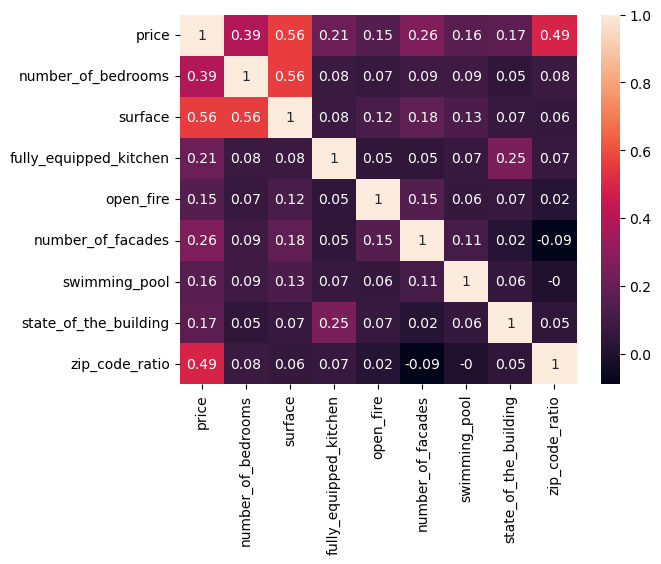

In [1769]:
correlation_matrix_house = df_house.corr().round(2)
sns.heatmap(data=correlation_matrix_house, annot=True)

<AxesSubplot:>

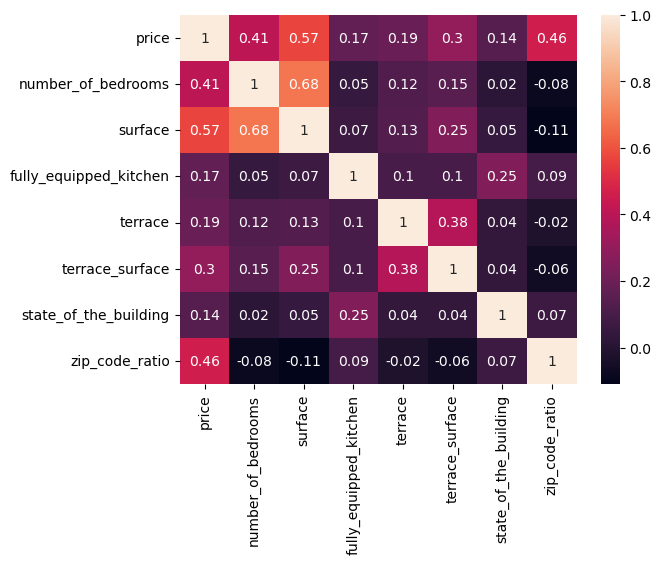

In [1770]:
correlation_matrix_apartment = df_apartment.corr().round(2)
sns.heatmap(data=correlation_matrix_apartment, annot=True)

## **ML regresion**

- learning rate
- overfiting
- test and plot
- use the same seed for shuffle
- use polinoms

### House model / Lineal Regresion

#### **Prepare** X and Y

In [1771]:
X = df_house.iloc[:,1:].values  #features

In [1772]:
Y = df_house.iloc[:,0].values  #target : price

#### **Split** the Data

In [1773]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18760, 8)
(4691, 8)
(18760,)
(4691,)


#### **Training and testing** the model

In [1774]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

#### **Model evaluation**

Evaluate our model using RMSE and R2-score.

In [1775]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 102052.43371762572
R2 score is 0.6025917364909643


In [1776]:
# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
RMSE is 104421.13068254606
R2 score is 0.6044773976142506


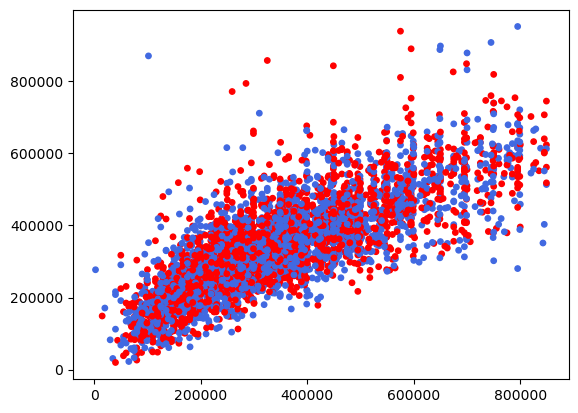

In [1777]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
plt.scatter(Y_test, y_test_predict, s=15).set_color(['royalblue','red'])
plt.show()

## **Polynominal Regresion**

### **House Model**

#### **Prepare** X and Y

In [1778]:
X = df_house.iloc[:,1:].values  #features

In [1779]:
Y = df_house.iloc[:,0].values  #target : price

#### **Split** the Data

In [1780]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18760, 8)
(4691, 8)
(18760,)
(4691,)


#### **Normalizing** Data

In [1781]:
scaler = StandardScaler().fit(X_train)

import pickle
pickle.dump(scaler, open('house_scaler.pkl','wb'))

In [1782]:
X_train = scaler.transform(X_train)

In [1783]:
X_test = scaler.transform(X_test)

#### **Model evaluation** 

In [1784]:
def create_polynomial_regression_model(degree):
    "Creates a polynomial regression model for the given degree"
    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
    # # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)

    # # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)

#     print("The model performance for the training set")
#     print("-------------------------------------------")
#     print("RMSE of training set is {}".format(rmse_train))
#     print("R2 score of training set is {}".format(r2_train))

#     print("\n")
  
#     print("The model performance for the test set")
#     print("-------------------------------------------")
#     print("RMSE of test set is {}".format(rmse_test))
#     print("R2 score of test set is {}".format(r2_test))
    
    result= {'Degree':degree,'rmse_train':round(rmse_train,2),'r2_train':round(r2_train,2),'rmse_test':round(rmse_test,2),'r2_test':round(r2_test,2)}
    return result

#### **Results**

In [1785]:
results_list = []

In [1786]:
for i in range(1,6):
    results_list.append(create_polynomial_regression_model(i))
    

In [1787]:
df_results = pd.DataFrame(results_list)

In [1788]:
df_results

,Degree,rmse_train,r2_train,rmse_test,r2_test
0,1,102052.43,0.60,1.044211e+05,6.000000e-01
1,2,97746.48,0.64,9.882637e+04,6.500000e-01
2,3,94625.00,0.66,9.693874e+04,6.600000e-01
3,4,92102.05,0.68,9.859682e+04,6.500000e-01
4,5,89565.85,0.69,2.121817e+12,-1.633091e+14


In [1789]:
val = df_results["Degree"].loc[df_results["r2_test"] == df_results["r2_test"].max()].values[0]

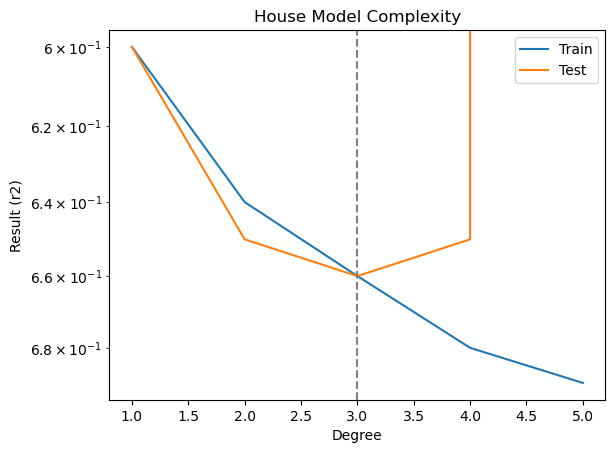

In [1790]:
plt.plot(df_results['Degree'], df_results['r2_train'], label='Train')
plt.plot(df_results['Degree'], df_results['r2_test'], label='Test')
plt.axvline(x=val,color='#808080', linestyle="dashed")
plt.yscale('log')
plt.legend()
plt.title('House Model Complexity')
plt.ylabel('Result (r2)')
plt.xlabel('Degree')
plt.gca().invert_yaxis()

**Final results**
* Underfit : < 3 Degrees
* **Correct fit : 3 Degrees**
* Overfit : > 3 Degrees

In [1791]:
# save the model to disk
# import joblib

poly_features = PolynomialFeatures(degree=3)
# transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)

filename = 'poly_features_model_house.pkl'
pickle.dump(poly_features, open(filename, 'wb'))

# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train)

filename = 'finalized_model_house.pkl'
# joblib.dump(model, filename)

pickle.dump(poly_model, open(filename, 'wb'))

### **Apartment Model**

#### **Prepare** X and Y

In [1792]:
X = df_apartment.iloc[:,1:].values  #features

In [1793]:
Y = df_apartment.iloc[:,0].values  #target : price

#### **Split** the Data

In [1794]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(15193, 7)
(3799, 7)
(15193,)
(3799,)


#### **Normalizing** Data

In [1795]:
scaler = StandardScaler().fit(X_train)

import pickle
pickle.dump(scaler, open('apartment_scaler.pkl','wb'))

In [1796]:
X_train = scaler.transform(X_train)

In [1797]:
X_test = scaler.transform(X_test)

#### **Model evaluation** 

In [1798]:
def create_polynomial_regression_model(degree):
    "Creates a polynomial regression model for the given degree"
    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
    # # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)

    # # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)

#     print("The model performance for the training set")
#     print("-------------------------------------------")
#     print("RMSE of training set is {}".format(rmse_train))
#     print("R2 score of training set is {}".format(r2_train))

#     print("\n")
  
#     print("The model performance for the test set")
#     print("-------------------------------------------")
#     print("RMSE of test set is {}".format(rmse_test))
#     print("R2 score of test set is {}".format(r2_test))
    
    result= {'Degree':degree,'rmse_train':round(rmse_train,2),'r2_train':round(r2_train,2),'rmse_test':round(rmse_test,2),'r2_test':round(r2_test,2)}
    return result

#### **Results**

In [1799]:
results_list = []

In [1800]:
for i in range(1,6):
    results_list.append(create_polynomial_regression_model(i))

In [1801]:
df_results = pd.DataFrame(results_list)

In [1802]:
df_results

,Degree,rmse_train,r2_train,rmse_test,r2_test
0,1,70799.57,0.65,73212.79,0.62
1,2,64831.90,0.71,67764.57,0.68
2,3,62856.46,0.72,65584.64,0.70
3,4,61469.31,0.74,65742.90,0.70
4,5,59915.47,0.75,72526.37,0.63


In [1803]:
val = df_results["Degree"].loc[df_results["r2_test"] == df_results["r2_test"].max()].values[0]

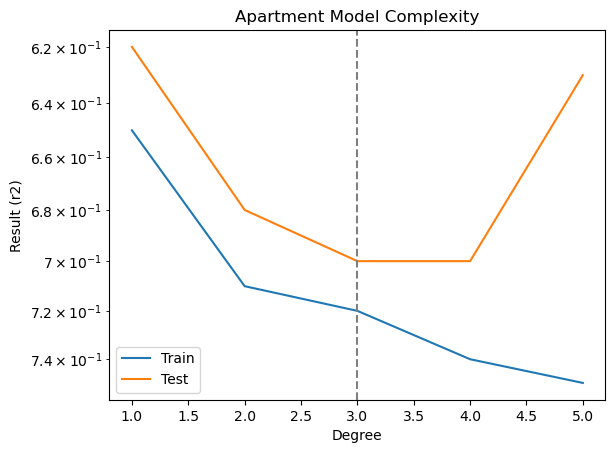

In [1804]:
plt.plot(df_results['Degree'], df_results['r2_train'], label='Train')
plt.plot(df_results['Degree'], df_results['r2_test'], label='Test')
plt.axvline(x=val,color='#808080', linestyle="dashed")
plt.yscale('log')
plt.legend()
plt.title('Apartment Model Complexity')
plt.ylabel('Result (r2)')
plt.xlabel('Degree')
plt.gca().invert_yaxis()

**Final results**
* Underfit : < 3 Degrees
* **Correct fit : 3 Degrees**
* Overfit : > 3 Degrees

In [1805]:
# save the model to disk
# import joblib

poly_features = PolynomialFeatures(degree=3)
# transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)

filename = 'poly_features_model_apartment.pkl'
pickle.dump(poly_features, open(filename, 'wb'))

# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train)

filename = 'finalized_model_apartment.pkl'
# joblib.dump(model, filename)

pickle.dump(poly_model, open(filename, 'wb'))

### **Other Model**

In [1806]:
df_other

,id,locality,postal_code,region,province,type_of_property,subtype_of_property,type_of_sale,price,number_of_bedrooms,...,open_fire,terrace,terrace_surface,garden,garden_surface,land_surface,number_of_facades,swimming_pool,state_of_the_building,zip_code_xx
106,9992033,Ham-sur-Sambre,5190,Wallonie,Namur,OTHER,OTHER_PROPERTY,residential_sale,278000,0,...,0,0,0,1,100,535,4,0,0.25,be_zip_519
199,9839029,Hastière-Lavaux,5540,Wallonie,Namur,OTHER,CHALET,residential_sale,118000,2,...,0,1,0,1,0,280,4,0,1.00,be_zip_554
265,10132676,Hastiere,5540,Wallonie,Namur,OTHER,CHALET,residential_sale,48000,1,...,0,0,0,1,0,211,4,0,0.50,be_zip_554
315,10062930,Hastiere,5540,Wallonie,Namur,OTHER,CHALET,residential_sale,99500,2,...,0,0,0,1,280,378,4,0,0.50,be_zip_554
418,9539560,Yvoir,5530,Wallonie,Namur,OTHER,CHALET,residential_sale,120000,1,...,0,1,0,0,0,494,4,0,0.75,be_zip_553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58471,10073234,Gent,9000,Flanders,East Flanders,OTHER,OTHER_PROPERTY,residential_sale,725000,3,...,0,1,41,1,41,332,2,0,0.50,be_zip_900
58952,9992767,Gent,9000,Flanders,East Flanders,OTHER,OTHER_PROPERTY,residential_sale,250000,3,...,0,0,0,0,0,0,4,0,0.25,be_zip_900
59939,10087034,EVERBEEK,9660,Flanders,East Flanders,OTHER,OTHER_PROPERTY,residential_sale,450000,8,...,0,1,0,0,0,3031,4,0,0.75,be_zip_966
59961,10131056,MUNKZWALM,9630,Flanders,East Flanders,OTHER,APARTMENT,residential_sale,430000,3,...,0,1,24,1,5500,5500,4,1,0.50,be_zip_963


In [1807]:
df_other.corr()['price']

/tmp/ipykernel_4873/921088034.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_other.corr()['price']


id                        0.082535
postal_code              -0.018252
price                     1.000000
number_of_bedrooms        0.623255
surface                   0.711486
fully_equipped_kitchen    0.108717
furnished                -0.130488
open_fire                 0.349570
terrace                   0.047398
terrace_surface           0.242407
garden                    0.091757
garden_surface            0.084122
land_surface              0.142626
number_of_facades        -0.096406
swimming_pool             0.218501
state_of_the_building     0.008930
Name: price, dtype: float64

#### **Prepare** X and Y

In [1808]:
X = df_other.iloc[:,1:].values  #features

In [1809]:
Y = df_other.iloc[:,0].values  #target : price

#### **Split** the Data

In [1810]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(157, 23)
(40, 23)
(157,)
(40,)


#### **Normalizing** Data

In [1811]:
scaler = StandardScaler().fit(X_train)

ValueError: could not convert string to float: 'Yvoir'

In [ ]:
X_train = scaler.transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

#### **Model evaluation** 

In [ ]:
def create_polynomial_regression_model(degree):
    "Creates a polynomial regression model for the given degree"
    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)

#     print("The model performance for the training set")
#     print("-------------------------------------------")
#     print("RMSE of training set is {}".format(rmse_train))
#     print("R2 score of training set is {}".format(r2_train))

#     print("\n")
  
#     print("The model performance for the test set")
#     print("-------------------------------------------")
#     print("RMSE of test set is {}".format(rmse_test))
#     print("R2 score of test set is {}".format(r2_test))
    
    result= {'Degree':degree,'rmse_train':round(rmse_train,2),'r2_train':round(r2_train,2),'rmse_test':round(rmse_test,2),'r2_test':round(r2_test,2)}
    return result

#### **Results**

In [ ]:
results_list = []

In [ ]:
for i in range(1,8):
    results_list.append(create_polynomial_regression_model(i))

In [ ]:
df_results = pd.DataFrame(results_list)

In [ ]:
df_results

In [ ]:
plt.plot(df_results['Degree'], df_results['r2_train'], label='Train')
plt.plot(df_results['Degree'], df_results['r2_test'], label='Test')
plt.yscale('log')
plt.legend()
plt.title('Apartment Model Complexity')
plt.ylabel('Result')
plt.xlabel('Degree')
plt.gca().invert_yaxis()

**Final results**
* Underfit : <= 4 Degrees
* **Correct fit : 5 Degrees**
* Overfit : >= 6 Degrees